# 1. Importing dependencies

In [1]:
!pip install ipython-autotime -q
%load_ext autotime

import sys, os
import zipfile
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
import optuna
import sklearn
import tensorflow as tf
from tensorflow.keras.utils import load_img, img_to_array
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Layer, Flatten, Input, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, AdamW, SGD, RMSprop
from tensorflow.keras.applications import VGG19, EfficientNetV2B0, EfficientNetV2B1, EfficientNetV2B2, EfficientNetV2B3, EfficientNetV2S, EfficientNetV2M, EfficientNetV2L
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input
from tensorflow.keras.applications.efficientnet_v2 import preprocess_input as efficientnetv2_preprocess_input
from tensorflow.keras.metrics import Accuracy, BinaryAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, auc, accuracy_score, f1_score

2024-08-02 14:43:49.596964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 14:43:49.597118: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 14:43:49.723971: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


time: 13.2 s (started: 2024-08-02 14:43:46 +00:00)


In [2]:
print("-"*50)
print(f"Python Version\t:")
!python --version
print("-"*50)
print(f"Numpy Version\t\t: {np.__version__}")
print(f"Pandas Version\t\t: {pd.__version__}")
print(f"Tensorflow Version\t: {tf.__version__}")
print(f"Matplotlib Version\t: {matplotlib.__version__}")
print(f"Seaborn Version\t\t: {sns.__version__}")
print(f"Scikit-learn Version\t: {sklearn.__version__}")
print(f"Optuna Version\t\t: {optuna.__version__}")
print(f"GPU Accelerator\t\t: {tf.config.list_physical_devices('GPU')}")
print("-"*50)

--------------------------------------------------
Python Version	:


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Python 3.10.13
--------------------------------------------------
Numpy Version		: 1.26.4
Pandas Version		: 2.2.2
Tensorflow Version	: 2.15.0
Matplotlib Version	: 3.7.5
Seaborn Version		: 0.12.2
Scikit-learn Version	: 1.2.2
Optuna Version		: 3.6.1
GPU Accelerator		: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
--------------------------------------------------
time: 1.18 s (started: 2024-08-02 14:43:59 +00:00)


In [3]:
!nvidia-smi

Fri Aug  2 14:44:02 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.90.07              Driver Version: 550.90.07      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   44C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# 2. Utils

## 2.1. Show Images

In [4]:
def show_images_from_generator(generator, num_images=5):
    sample_images, sample_labels = next(generator)

    fig, axes = plt.subplots(1, num_images, figsize=(20, 20))
    axes = axes.flatten()
    for img, label, ax in zip(sample_images[:num_images], sample_labels[:num_images], axes):
        ax.imshow(img)
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

time: 1.23 ms (started: 2024-08-02 14:44:02 +00:00)


## 2.2. EDA

In [5]:
def show_number_of_sample_train_test(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    # Calculate class counts for train, valid, and test sets
    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    # Sum train and validation counts
    total_train_valid_counts = train_class_count[1] + valid_class_count[1]

    plt.figure(figsize=(10, 5))

    # Combined Train + Validation Set
    plt.subplot(1, 2, 1)
    sns.barplot(x=class_names, y=total_train_valid_counts, palette=['mediumturquoise', 'orangered'])
    plt.title('Total Train + Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(total_train_valid_counts):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 2, 2)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 7.53 ms (started: 2024-08-02 14:44:02 +00:00)


In [6]:
def show_number_of_sample(train_set, valid_set, test_set):
    class_names = list(train_set.class_indices.keys())

    train_class_count = np.unique(train_set.classes, return_counts=True)
    valid_class_count = np.unique(valid_set.classes, return_counts=True)
    test_class_count = np.unique(test_set.classes, return_counts=True)

    plt.figure(figsize=(15, 5))

    # Train Set
    plt.subplot(1, 3, 1)
    sns.barplot(x=class_names, y=train_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Train Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(train_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Validation Set
    plt.subplot(1, 3, 2)
    sns.barplot(x=class_names, y=valid_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Validation Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(valid_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    # Test Set
    plt.subplot(1, 3, 3)
    sns.barplot(x=class_names, y=test_class_count[1], palette=['mediumturquoise', 'orangered'])
    plt.title('Test Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    for index, value in enumerate(test_class_count[1]):
        plt.text(index, value, str(value), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 4.08 ms (started: 2024-08-02 14:44:02 +00:00)


In [7]:
def show_number_of_data_separation_train_test(train_set, valid_set, test_set):

    # Calculate the total number of samples in each set
    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    # Combine train and validation samples
    total_train_valid_samples = total_train_samples + total_valid_samples
    total_samples = total_train_valid_samples + total_test_samples

    # Calculate the percentages
    train_valid_percentage = (total_train_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    # Pie chart
    labels = ['Train + Validation', 'Test']
    sizes = [train_valid_percentage, test_percentage]
    colors = ['gold', 'lightcoral']
    explode = (0.1, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPercentage of Data Samples\n')

    # Bar chart
    categories = ['Train + Validation', 'Test']
    counts = [total_train_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Number of Samples')
    ax2.set_title('\nNumber of Samples in Each Set\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()


time: 5.7 ms (started: 2024-08-02 14:44:02 +00:00)


In [8]:
def show_number_of_data_separation(train_set, valid_set, test_set):

    total_train_samples = len(train_set.labels)
    total_valid_samples = len(valid_set.labels)
    total_test_samples = len(test_set.labels)

    total_samples = total_train_samples + total_valid_samples + total_test_samples

    train_percentage = (total_train_samples / total_samples) * 100
    valid_percentage = (total_valid_samples / total_samples) * 100
    test_percentage = (total_test_samples / total_samples) * 100

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw={'wspace': 0.4})

    labels = ['Train', 'Validation', 'Test']
    sizes = [train_percentage, valid_percentage, test_percentage]
    colors = ['gold', 'yellowgreen', 'lightcoral']
    explode = (0.1, 0, 0)  # explode 1st slice
    ax1.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
    ax1.axis('equal')
    ax1.set_title('\nPersentase Jumlah Data\n')

    categories = ['Train', 'Validation', 'Test']
    counts = [total_train_samples, total_valid_samples, total_test_samples]
    bars = ax2.bar(categories, counts, color=colors)
    ax2.set_ylabel('Jumlah Data')
    ax2.set_title('\nJumlah Data dalam Setiap Kategori\n')

    for bar, count in zip(bars, counts):
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width() / 2, height, count, ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

time: 4.92 ms (started: 2024-08-02 14:44:02 +00:00)


In [9]:
def count_datasets(dir_path):
    img_count_author_asli = 0
    img_count_author_palsu = 0
    img_count_external_asli = 0
    img_count_external_palsu = 0

    for dirpath, dirnames, filenames in os.walk(dir_path):
        if 'Asli' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_asli += 1
                else:
                    img_count_external_asli += 1
        elif 'Palsu' in dirpath:
            for filename in filenames:
                if filename.startswith("IMG_"):
                    img_count_author_palsu += 1
                else:
                    img_count_external_palsu += 1

    return img_count_author_asli, img_count_author_palsu, img_count_external_asli, img_count_external_palsu

def show_count_datasets(dir_path):
    author_asli, author_palsu, external_asli, external_palsu = count_datasets(dir_path)

    labels = ['Hasil Pemotretan Penulis', 'Sumber Eksternal']
    counts_asli = [author_asli, external_asli]
    counts_palsu = [author_palsu, external_palsu]

    x = range(len(labels))
    bar_width = 0.35

    plt.bar(x, counts_asli, width=bar_width, label='Asli', color='mediumturquoise', align='center')
    plt.bar([i + bar_width for i in x], counts_palsu, width=bar_width, label='Palsu', color='orangered', align='center')

    for i, v in enumerate(counts_asli):
        plt.text(i - 0.1, v + 5, str(v), color='black')

    for i, v in enumerate(counts_palsu):
        plt.text(i + bar_width - 0.1, v + 5, str(v), color='black')

    plt.xlabel('Sumber Dataset')
    plt.ylabel('Jumlah Gambar')
    plt.title('Perbandingan Jumlah Dataset')
    plt.xticks([i + bar_width / 2 for i in x], labels)
    plt.legend()
    plt.show()

time: 4.49 ms (started: 2024-08-02 14:44:02 +00:00)


## 2.3. Callbacks Preparation

In [10]:
def callbacks_list(monitor='val_loss', model_save_pathname='best_model.keras', early_stopping_patience=5, learning_rate_patience=3, learning_rate_scheme=0):
    '''TensorBoard'''
    # log_folder = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    # tb_callbacks = TensorBoard(log_dir=log_folder)
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    '''EarlyStoping'''
    cnn_es_callback = EarlyStopping(monitor=monitor, min_delta=0, patience=early_stopping_patience, verbose=1)

    '''ModelCheckPoint'''
    cnn_mpt_callback = ModelCheckpoint(filepath=model_save_pathname, monitor=monitor, mode='auto', save_best_only=True, verbose=1)

    '''LearningRateScheduler'''
    def learning_rate_schedule(epoch, lr):
        if epoch < 10:
            return lr
        else:
            return float(lr * tf.math.exp(-0.1))

    lr_scheduler = LearningRateScheduler(learning_rate_schedule, verbose=1)

    '''ReduceLROnPlateau'''
    lr_reduction = ReduceLROnPlateau(monitor=monitor, factor=0.5, patience=learning_rate_patience, min_lr=1e-8, verbose=1)

    '''ReturnCallbacks'''
    if learning_rate_scheme == 0:
        callbacks = [cnn_es_callback, cnn_mpt_callback]
    elif learning_rate_scheme == 1:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_scheduler]
    elif learning_rate_scheme == 2:
        callbacks = [cnn_es_callback, cnn_mpt_callback, lr_reduction]
    else:
        callbacks = []
        print('The value for learning_rate_scheme is only 0, 1, or 2.')

    return callbacks

time: 2.76 ms (started: 2024-08-02 14:44:02 +00:00)


## 2.4. Evaluation Preparation

In [11]:
class History():
    def __init__(self, history, model_name='MODEL'):
        self.history = history
        self.model_name = model_name

    def plot_accuracy_and_lost(self):
        history = self.history

        fig, axs = plt.subplots(1, 2, figsize=(10, 5))

        axs[0].plot(history.history['accuracy'], linestyle='--', label='accuracy')
        axs[0].plot(history.history['val_accuracy'], linestyle='-.', label='val_accuracy', )
        axs[0].set_title(f"\n{self.model_name} Accuracy\n")
        axs[0].set_xlabel('Epochs')
        axs[0].set_ylabel('Accuracy')
        axs[0].legend()

        axs[1].plot(history.history['loss'], linestyle='--', label='loss')
        axs[1].plot(history.history['val_loss'], linestyle='-.', label='val_loss', )
        axs[1].set_title(f"\n{self.model_name} Loss\n")
        axs[1].set_xlabel('Epochs')
        axs[1].set_ylabel('Loss')
        axs[1].legend()

        plt.tight_layout()
        plt.show()

    def plot_learningrate(self):
        history = self.history

        plt.plot(history.history['learning_rate'], color='orangered', linestyle='--', marker='o', label='learning_rate')
        plt.xlabel('Epoch')
        plt.ylabel('Learning Rate')
        plt.title(f'\n{self.model_name} Learning Rate\n')
        plt.legend()
        plt.show()

time: 6.18 ms (started: 2024-08-02 14:44:02 +00:00)


In [12]:
class ModelEvaluation():
    def __init__(self, model, test_set, model_name='MODEL'):
        self.model = model
        self.test_set = test_set
        self.y_true = test_set.classes
        self.y_pred = model.predict(test_set)
        self.model_name = model_name

    def evaluate(self):
        return self.model.evaluate(self.test_set)
    
    def predict_test(self):
        return self.y_true, self.y_pred

    def confusion_matrix(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        conf_matrix = confusion_matrix(y_true, y_pred_classes)
        return conf_matrix

    def classification_report(self):
        y_true = self.y_true
        y_pred = self.y_pred
        y_pred_classes = np.argmax(y_pred, axis=1)
        target_names = list(self.test_set.class_indices.keys())
        print(f"{self.model_name} Classification Report")
        print(classification_report(y_true, y_pred_classes, target_names=target_names))

    def roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        roc_auc = {}
        target_names = list(self.test_set.class_indices.keys())
        for i in range(len(target_names)):
            roc_auc[target_names[i]] = roc_auc_score((y_true == i).astype(int), y_pred[:, i])
        return roc_auc

    def plot_confusion_matrix(self):
        conf_matrix = self.confusion_matrix()
        labels = list(self.test_set.class_indices.keys())
        plt.figure(figsize=(8, 6))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='magma', xticklabels=labels, yticklabels=labels)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title(f'{self.model_name} Confusion Matrix')
        plt.show()

    def plot_roc_auc(self):
        y_true = self.y_true
        y_pred = self.y_pred
        n_classes = len(np.unique(y_true))

        fpr, tpr, _ = roc_curve(y_true == 0, y_pred[:, 0])
        roc_auc = auc(fpr, tpr)

        plt.figure(figsize=(8, 6))
        lw = 2
        plt.plot(fpr, tpr, lw=lw, label='ROC class "{}" (AUC area = {:.2f})'.format(list(self.test_set.class_indices.keys())[0], roc_auc))
        plt.fill_between(fpr, tpr, color='orange', alpha=0.3)
        plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{self.model_name} ROC Curve')
        plt.legend(loc="lower right")
        plt.show()

time: 2.91 ms (started: 2024-08-02 14:44:02 +00:00)


In [13]:
def history_to_dataframe(history, filename='model'):
    
    df = pd.DataFrame(history.history)
    
    val_loss_min = df['val_loss'].min()
    val_loss_epoch = df['val_loss'].idxmin()
    
    train_loss_min = df['loss'].min()
    train_loss_epoch = df['loss'].idxmin()
    
    print(f'Validation Loss Terendah: {val_loss_min:.4f} pada Epoch: {val_loss_epoch+1}')
    print(f'Training Loss Terendah: {train_loss_min:.4f} pada Epoch: {train_loss_epoch+1}')
    
    val_acc_max = df['val_accuracy'].max()
    val_acc_epoch = df['val_accuracy'].idxmax()
    
    train_acc_max = df['accuracy'].max()
    train_acc_epoch = df['accuracy'].idxmax()
    
    print(f'Validation Accuracy Tertinggi: {val_acc_max:.4f} pada Epoch: {val_acc_epoch+1}')
    print(f'Training Accuracy Tertinggi: {train_acc_max:.4f} pada Epoch: {train_acc_epoch+1}')
    
    df.to_csv(f'history_{filename}.csv', index=False)

    return df


time: 8.25 ms (started: 2024-08-02 14:44:02 +00:00)


## 2.5. Train and Calculate Model Execution Time

In [14]:
def train_model_with_callbacks(model, training_set, validation_set, epochs=1, batch_size=32, verbose='auto', callbacks=[]):
    print("="*50)
    print("\t\tSTART TRAINING")
    print("="*50+"\n")

    try:
        start_time = time.time()

        history = model.fit(
            training_set,
            validation_data=validation_set,
            epochs=epochs,
            batch_size=batch_size,
            verbose=verbose,
            callbacks=callbacks,
        )

        end_time = time.time()
    except tf.errors.ResourceExhaustedError as e:
        print()
        print("-"*50)
        print("Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!")
        # print(e)
        print("-"*50)
    else:
        duration_seconds = end_time - start_time
        duration_minutes = duration_seconds // 60
        duration_seconds_modulo =  duration_seconds % 60
        duration_seconds_per_epoch = duration_seconds / len(history.history['learning_rate'])

        print()
        print("="*50)
        print("\t\tTRAINING COMPLETE")
        print("="*50)
        print(f"Total training Time:\n{int(duration_minutes)} minutes {int(duration_seconds_modulo)} seconds ({duration_seconds} total seconds).")
        print(f"Training Time Per Epoch:\n{duration_seconds_per_epoch:.2f}s/epoch")
        print(f"Total Epoch:\n{len(history.history['learning_rate'])}")
        print("="*50)

        return history

    print()
    print("="*50)
    print("\t\tTRAINING COMPLETE")
    print("="*50)

time: 7.04 ms (started: 2024-08-02 14:44:02 +00:00)


# 3. Config

In [15]:
class Config:
    IMAGE_SIZE = 448 # option: 256, 448, 512
    BATCH_SIZE = 64 # option: 32, 64
    SEED = 42 # default 42
    LABEL_MODE = 'categorical'
    VAL_SPLIT = 0.2 # option: 0.3, 0.2
    COLOR_MODE = 'rgb'
    CHANNEL = 3
    MONITOR = 'val_loss'
    LR = 1e-05 # best 1e-05
    LOSSES = CategoricalCrossentropy()
    METRICS = ['accuracy']
    ES_PATIENCE = 10 # mostly 15
    LR_PATIENCE = 5 # mostly 5
    LR_SCHEME = 2 # mostly 2
    EPOCH = 1000
    OUTPUT_LAYER = 2
    OUTPUT_ACTIVATION = 'softmax'

time: 8.34 ms (started: 2024-08-02 14:44:02 +00:00)


In [16]:
np.random.seed(Config.SEED)
tf.random.set_seed(Config.SEED)
# tf.config.experimental.enable_op_determinism()

time: 4.93 ms (started: 2024-08-02 14:44:02 +00:00)


# 4. Load Dataset

In [17]:
count = 0
for root, folders, filenames in os.walk('/kaggle/input'):
   print(root, folders)

/kaggle/input ['test', 'train']
/kaggle/input/test ['Asli', 'Palsu']
/kaggle/input/test/Asli []
/kaggle/input/test/Palsu []
/kaggle/input/train ['Asli', 'Palsu']
/kaggle/input/train/Asli []
/kaggle/input/train/Palsu []
time: 353 ms (started: 2024-08-02 14:44:02 +00:00)


In [18]:
dir_path = '/kaggle/input/'
train_set_dir = dir_path + '/train'
test_set_dir = dir_path + '/test'

for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"Terdapat {len(dirnames)} direktori and {len(filenames)} file gambar di '{dirpath}'.")

Terdapat 2 direktori and 0 file gambar di '/kaggle/input/'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/test'.
Terdapat 0 direktori and 165 file gambar di '/kaggle/input/test/Asli'.
Terdapat 0 direktori and 53 file gambar di '/kaggle/input/test/Palsu'.
Terdapat 2 direktori and 0 file gambar di '/kaggle/input/train'.
Terdapat 0 direktori and 708 file gambar di '/kaggle/input/train/Asli'.
Terdapat 0 direktori and 162 file gambar di '/kaggle/input/train/Palsu'.
time: 7.02 ms (started: 2024-08-02 14:44:02 +00:00)


# 5. Dataset Generator (With Augment) and Visualization

In [19]:
train_datagen = ImageDataGenerator(
    rescale=1/255.,
#     rotation_range=180,
#     width_shift_range=0.01,
#     height_shift_range=0.01,
#     shear_range=0.05,
#     zoom_range=0.1,
#     horizontal_flip=False,
#     vertical_flip=False,
#     fill_mode='nearest',
    validation_split=Config.VAL_SPLIT,
)

valid_datagen = ImageDataGenerator(
    rescale=1/255.,
    validation_split=Config.VAL_SPLIT,
)

test_datagen = ImageDataGenerator(
    rescale=1./255.,
)

time: 951 µs (started: 2024-08-02 14:44:02 +00:00)


In [20]:
train_set = train_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    color_mode=Config.COLOR_MODE,
    subset='training',
    seed=Config.SEED,
)

valid_set = valid_datagen.flow_from_directory(
    directory=train_set_dir,
    shuffle=True,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
    subset='validation',
    color_mode=Config.COLOR_MODE,
    seed=Config.SEED,
)

test_set = test_datagen.flow_from_directory(
    directory=test_set_dir,
    shuffle=False,
    target_size=(Config.IMAGE_SIZE, Config.IMAGE_SIZE),
    batch_size=Config.BATCH_SIZE,
    class_mode=Config.LABEL_MODE,
)

Found 697 images belonging to 2 classes.
Found 173 images belonging to 2 classes.
Found 218 images belonging to 2 classes.
time: 56.4 ms (started: 2024-08-02 14:44:02 +00:00)


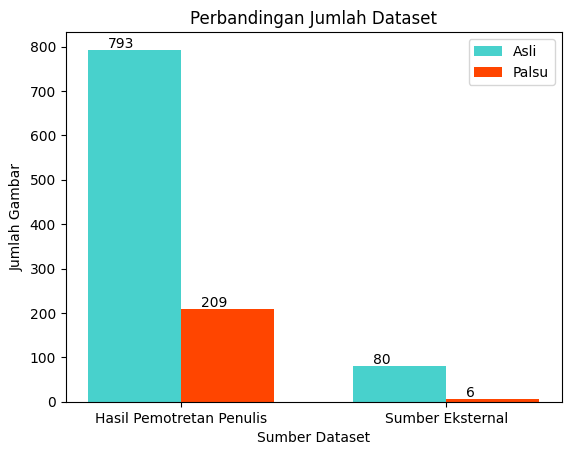

time: 307 ms (started: 2024-08-02 14:44:02 +00:00)


In [21]:
show_count_datasets(dir_path)

/tmp/ipykernel_34/1519368549.py:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


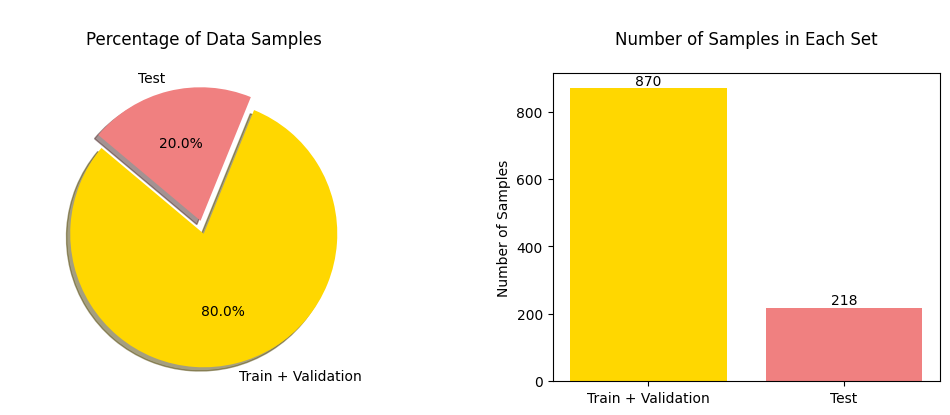

time: 342 ms (started: 2024-08-02 14:44:03 +00:00)


In [22]:
show_number_of_data_separation_train_test(train_set, valid_set, test_set)

In [23]:
# show_number_of_data_separation(train_set, valid_set, test_set)

time: 391 µs (started: 2024-08-02 14:44:03 +00:00)


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


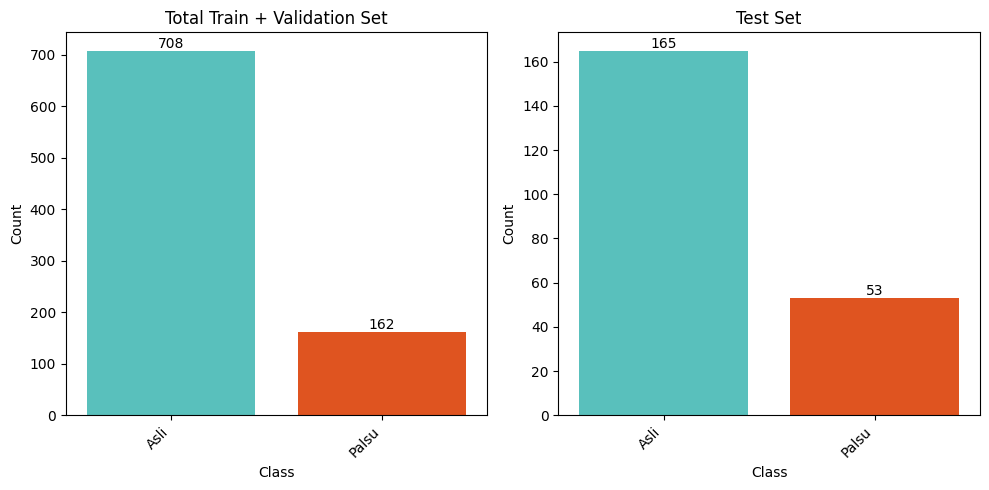

time: 490 ms (started: 2024-08-02 14:44:03 +00:00)


In [24]:
show_number_of_sample_train_test(train_set, valid_set, test_set)

In [25]:
# show_number_of_sample(train_set, valid_set, test_set)

time: 373 µs (started: 2024-08-02 14:44:03 +00:00)


In [26]:
test_set.class_indices

{'Asli': 0, 'Palsu': 1}

time: 11.1 ms (started: 2024-08-02 14:44:03 +00:00)


Train Set:


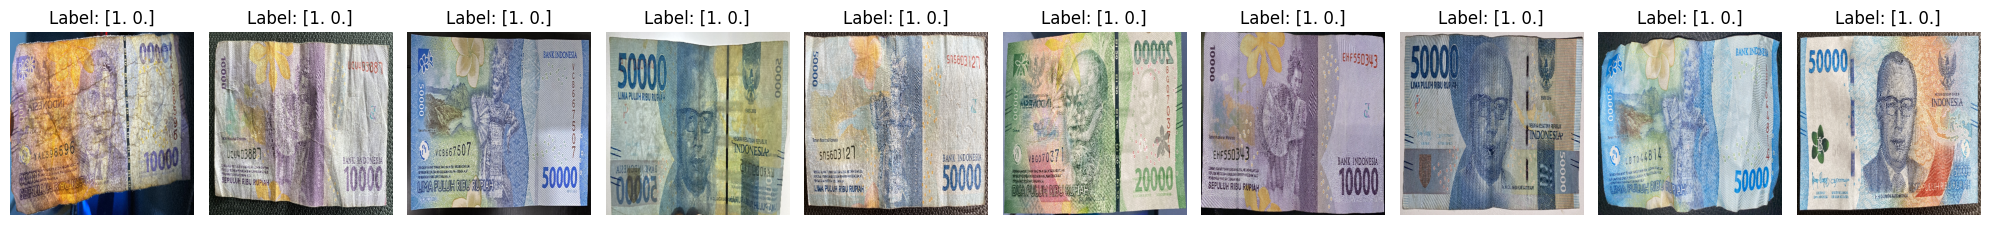

Validation Set:


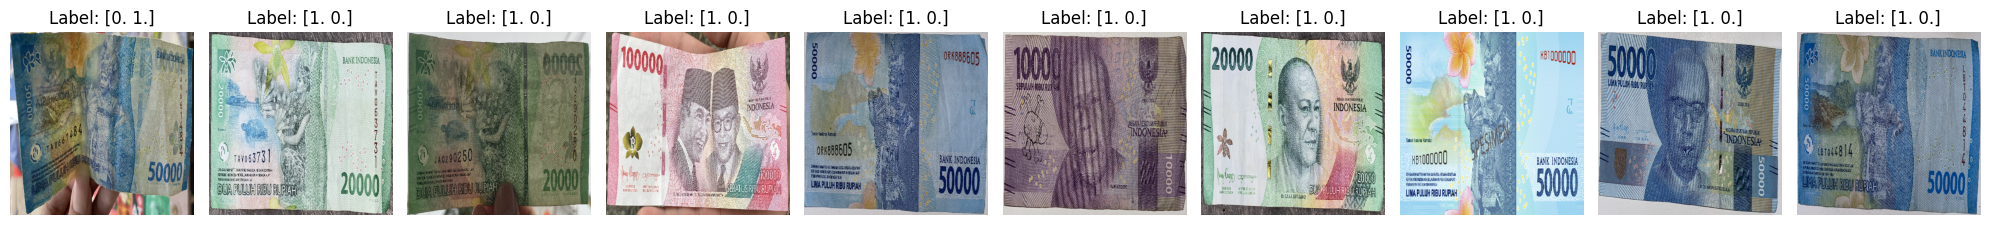

Test Set:


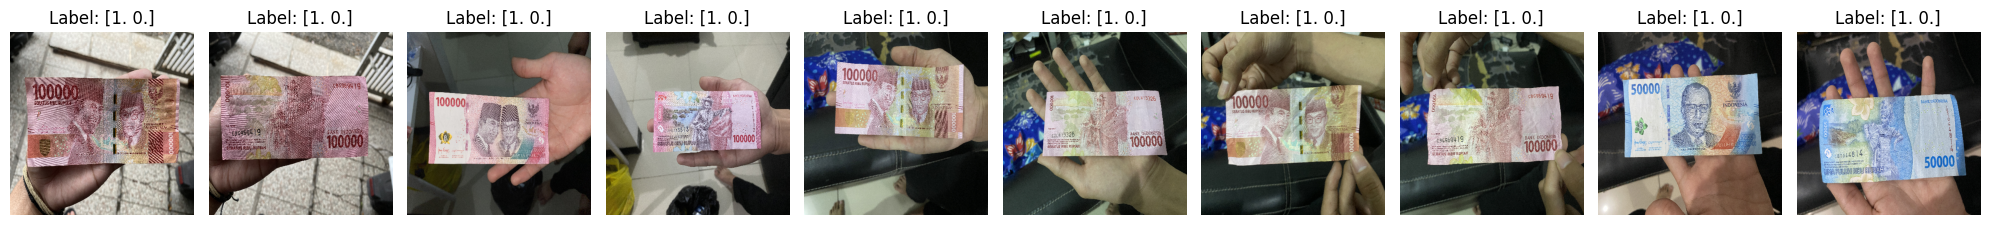

time: 19.7 s (started: 2024-08-02 14:44:04 +00:00)


In [27]:
print("Train Set:")
show_images_from_generator(train_set, num_images=10)

print("Validation Set:")
show_images_from_generator(valid_set, num_images=10)

print("Test Set:")
show_images_from_generator(test_set, num_images=10)

# 6. Building Models

## 6.1. Custom CNN

In [28]:
cnn_model = Sequential(name='custom_cnn_model')

cnn_model.add(Input(shape=(Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL)))

cnn_model.add(Conv2D(filters=32, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Conv2D(filters=128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='valid',))

cnn_model.add(Flatten())

cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dropout(0.2))

cnn_model.add(Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION))

cnn_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

cnn_model.summary(show_trainable=True)

Model: "custom_cnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ conv2d (Conv2D)             │ (None, 446, 446, 32)  │        896 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d               │ (None, 223, 223, 32)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_1 (Conv2D)           │ (None, 221, 221, 64)  │     18,496 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_1             │ (None, 110, 110, 64)  │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_2 (Conv2D)           │ (None, 108, 108, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_2             │ (None, 54, 54, 64)    │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_3 (Conv2D)           │ (None, 52, 52, 128)   │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_3             │ (None, 26, 26, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ conv2d_4 (Conv2D)           │ (None, 24, 24, 128)   │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ max_pooling2d_4             │ (None, 12, 12, 128)   │          0 │   -   │
│ (MaxPooling2D)              │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ flatten (Flatten)           │ (None, 18432)         │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense (Dense)               │ (None, 512)           │  9,437,696 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout (Dropout)           │ (None, 512)           │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_1 (Dense)             │ (None, 2)             │      1,026 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 9,716,482 (37.07 MB)

 Trainable params: 9,716,482 (37.07 MB)

 Non-trainable params: 0 (0.00 B)

time: 675 ms (started: 2024-08-02 14:44:23 +00:00)


In [29]:
# plot_model(
#     cnn_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='cnn_model.png'
#     )

time: 533 µs (started: 2024-08-02 14:44:24 +00:00)


## 6.2. VGG-19

In [30]:
vgg19_base_model = VGG19(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

vgg19_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(vgg19_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

vgg19_model = Model(inputs=vgg19_base_model.input, outputs=x, name='vgg19_model')

vgg19_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

vgg19_model.summary(show_trainable=True)

80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg19_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_1 (InputLayer)  │ (None, 448, 448, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv1 (Conv2D)       │ (None, 448, 448, 64)  │      1,792 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_conv2 (Conv2D)       │ (None, 448, 448, 64)  │     36,928 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block1_pool (MaxPooling2D)  │ (None, 224, 224, 64)  │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv1 (Conv2D)       │ (None, 224, 224, 128) │     73,856 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_conv2 (Conv2D)       │ (None, 224, 224, 128) │    147,584 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block2_pool (MaxPooling2D)  │ (None, 112, 112, 128) │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv1 (Conv2D)       │ (None, 112, 112, 256) │    295,168 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv2 (Conv2D)       │ (None, 112, 112, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv3 (Conv2D)       │ (None, 112, 112, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_conv4 (Conv2D)       │ (None, 112, 112, 256) │    590,080 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block3_pool (MaxPooling2D)  │ (None, 56, 56, 256)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv1 (Conv2D)       │ (None, 56, 56, 512)   │  1,180,160 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv2 (Conv2D)       │ (None, 56, 56, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv3 (Conv2D)       │ (None, 56, 56, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_conv4 (Conv2D)       │ (None, 56, 56, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block4_pool (MaxPooling2D)  │ (None, 28, 28, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv1 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv2 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv3 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_conv4 (Conv2D)       │ (None, 28, 28, 512)   │  2,359,808 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ block5_pool (MaxPooling2D)  │ (None, 14, 14, 512)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d    │ (None, 512)           │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 512)           │    262,656 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼─────

 Total params: 20,288,066 (77.39 MB)

 Trainable params: 20,288,066 (77.39 MB)

 Non-trainable params: 0 (0.00 B)

time: 881 ms (started: 2024-08-02 14:44:24 +00:00)


In [31]:
# plot_model(
#     vgg19_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='vgg19_model.png'
#     )

time: 569 µs (started: 2024-08-02 14:44:25 +00:00)


## 6.3. EficientNetV2B2

In [32]:
efficientnetv2b2_base_model = EfficientNetV2B2(
    include_top = False,
    weights = 'imagenet',
    input_shape = (Config.IMAGE_SIZE, Config.IMAGE_SIZE, Config.CHANNEL),
    pooling='avg',
)

efficientnetv2b2_base_model.trainable = True

# x = GlobalAveragePooling2D()(efficientnetv2_base_model.output) # pooling = 'avg'
x = Dense(units=512, activation='relu')(efficientnetv2b2_base_model.output)
# x = Dense(units=512, activation='relu')(x)
x = Dense(units=Config.OUTPUT_LAYER, activation=Config.OUTPUT_ACTIVATION)(x)

efficientnetv2b2_model = Model(inputs=efficientnetv2b2_base_model.input, outputs=x, name='efficientnetv2b2_model')

efficientnetv2b2_model.compile(
    loss=CategoricalCrossentropy(),
    optimizer=AdamW(learning_rate=Config.LR),
    metrics=['accuracy'],
)

efficientnetv2b2_model.summary(show_trainable=True)

35839040/35839040 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "efficientnetv2b2_model"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2     │ (None, 448,     │         0 │ -              │   -   │
│ (InputLayer)      │ 448, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ rescaling         │ (None, 448,     │         0 │ input_layer_2… │   -   │
│ (Rescaling)       │ 448, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ normalization     │ (None, 448,     │         0 │ rescaling[0][… │   -   │
│ (Normalization)   │ 448, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_conv         │ (None, 224,     │       864 │ normalization… │   Y   │
│ (Conv2D)          │ 224, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_bn           │ (None, 224,     │       128 │ stem_conv[0][… │   Y   │
│ (BatchNormalizat… │ 224, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ stem_activation   │ (None, 224,     │         0 │ stem_bn[0][0]  │   -   │
│ (Activation)      │ 224, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 224,     │     4,608 │ stem_activati… │   Y   │
│ (Conv2D)          │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 224,     │        64 │ block1a_proje… │   Y   │
│ (BatchNormalizat… │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1a_project_… │ (None, 224,     │         0 │ block1a_proje… │   -   │
│ (Activation)      │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 224,     │     2,304 │ block1a_proje… │   Y   │
│ (Conv2D)          │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 224,     │        64 │ block1b_proje… │   Y   │
│ (BatchNormalizat… │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_project_… │ (None, 224,     │         0 │ block1b_proje… │   -   │
│ (Activation)      │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_drop      │ (None, 224,     │         0 │ block1b_proje… │   -   │
│ (Dropout)         │ 224, 16)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1b_add (Add) │ (None, 224,     │         0 │ block1b_drop[… │   -   │
│                   │ 224, 16)        │           │ block1a_proje… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_c… │ (None, 112,     │     9,216 │ block1b_add[0… │   Y   │
│ (Conv2D)          │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_bn │ (None, 112,     │       256 │ block2a_expan… │   Y   │
│ (BatchNormalizat… │ 112, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2a_expand_a… │ (None, 112,     │         0 │ block2a_expan… │   - 

 Total params: 9,491,808 (36.21 MB)

 Trainable params: 9,409,520 (35.89 MB)

 Non-trainable params: 82,288 (321.44 KB)

time: 3.05 s (started: 2024-08-02 14:44:25 +00:00)


In [33]:
# plot_model(
#     efficientnetv2b2_model, 
#     show_shapes=True, 
#     show_dtype=False, 
#     show_layer_names=True,
#     rankdir="TB",
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True,
#     show_trainable=True,
#     to_file='efficientnetv2b2_model.png'
#     )

time: 575 µs (started: 2024-08-02 14:44:28 +00:00)


# 7. Training

## 7.1. Custom CNN

In [34]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='cnn_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

cnn_history = train_model_with_callbacks(
    model=cnn_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2024-08-02 14:45:11.765756: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,32,446,446]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,448,448]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 14:45:13.716235: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199096: 5.97657, expected 5.2613

 1/11 ━━━━━━━━━━━━━━━━━━━━ 11:29 69s/step - accuracy: 0.8281 - loss: 0.6210

I0000 00:00:1722609945.798291     139 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1722609945.821644     139 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 5/11 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.8363 - loss: 0.5730

2024-08-02 14:45:56.961723: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[57,32,446,446]{3,2,1,0}, u8[0]{0}) custom-call(f32[57,3,448,448]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 14:45:58.484883: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199002: 6.36652, expected 5.62516
2024-08-02 14:45:58.484950: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199003: 6.22148, expected 5.48012
2024-08-02 14:45:58.484960: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 199007: 6.39449, expected 5.65313
2024-08-02 14:45:58.484969: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.8251 - loss: 0.5480

W0000 00:00:1722609992.638213     136 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-08-02 14:46:37.358157: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[45,32,446,446]{3,2,1,0}, u8[0]{0}) custom-call(f32[45,3,448,448]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 14:46:38.367520: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198916: 7.68216, expected 6.76883
2024-08-02 14:46:38.367580: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198918: 8.0191, expected 7.10577
2024-08-02 14:46:38.367600: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 


Epoch 1: val_loss improved from inf to 0.49603, saving model to cnn_best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 130s 6s/step - accuracy: 0.8241 - loss: 0.5451 - val_accuracy: 0.8150 - val_loss: 0.4960 - learning_rate: 1.0000e-05
Epoch 2/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.8195 - loss: 0.4623
Epoch 2: val_loss improved from 0.49603 to 0.49180, saving model to cnn_best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.8190 - loss: 0.4629 - val_accuracy: 0.8150 - val_loss: 0.4918 - learning_rate: 1.0000e-05
Epoch 3/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 950ms/step - accuracy: 0.8004 - loss: 0.4786
Epoch 3: val_loss improved from 0.49180 to 0.48546, saving model to cnn_best_model.keras
11/11 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8015 - loss: 0.4773 - val_accuracy: 0.8150 - val_loss: 0.4855 - learning_rate: 1.0000e-05
Epoch 4/1000
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 945ms/step - accuracy: 0.8079 - loss: 0.4650
Epoch 4: val_loss improved from 0.48546 to

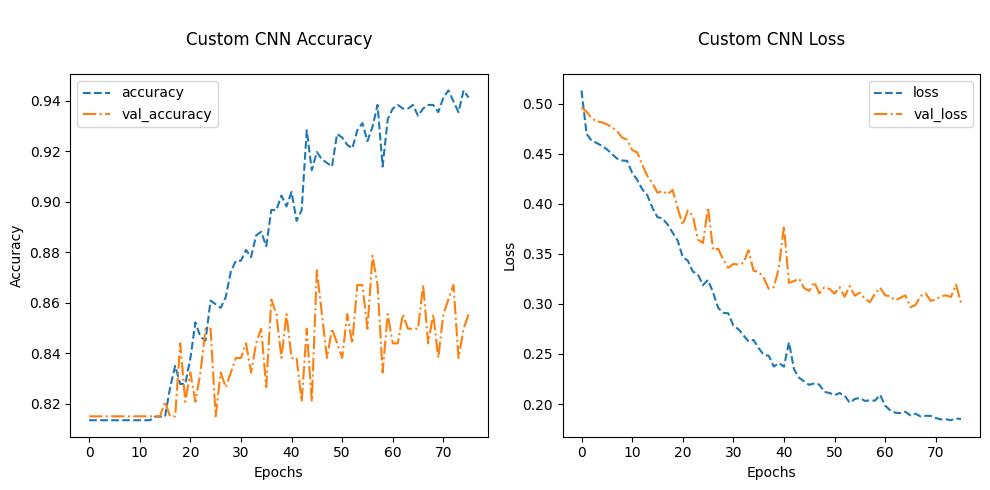

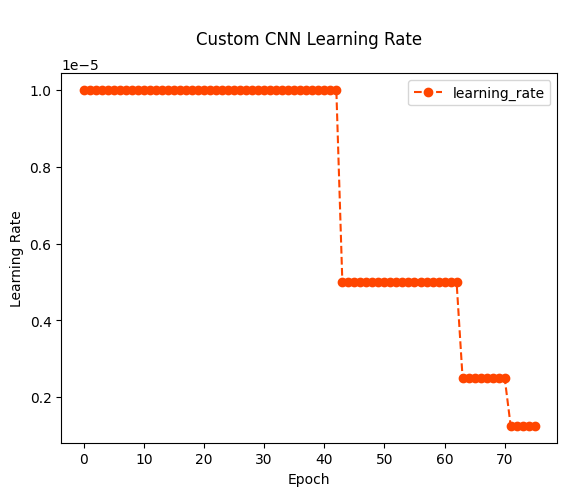

time: 706 ms (started: 2024-08-02 15:32:39 +00:00)


In [35]:
try:
    History(cnn_history, model_name='Custom CNN').plot_accuracy_and_lost()
    History(cnn_history, model_name='Custom CNN').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

In [36]:
try:
    history_df = history_to_dataframe(cnn_history, 'custom_CNN')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

Validation Loss Terendah: 0.2966 pada Epoch: 66
Training Loss Terendah: 0.1838 pada Epoch: 74
Validation Accuracy Tertinggi: 0.8786 pada Epoch: 57
Training Accuracy Tertinggi: 0.9440 pada Epoch: 72
time: 6.77 ms (started: 2024-08-02 15:32:40 +00:00)


## 7.2. VGG-19

In [37]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='vgg19_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

vgg19_history = train_model_with_callbacks(
    model=vgg19_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


2024-08-02 15:33:14.177565: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[64,64,448,448]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,3,448,448]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 15:33:18.846379: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.51857, expected 2.6475
2024-08-02 15:33:18.846430: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.92375, expected 4.05268
2024-08-02 15:33:18.846452: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 6.04286, expected 5.1718
2024-08-02 15:33:18.846470: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Dif


--------------------------------------------------
Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!
--------------------------------------------------

		TRAINING COMPLETE
time: 4min 44s (started: 2024-08-02 15:32:40 +00:00)



Kesalahan: History training tidak ada!



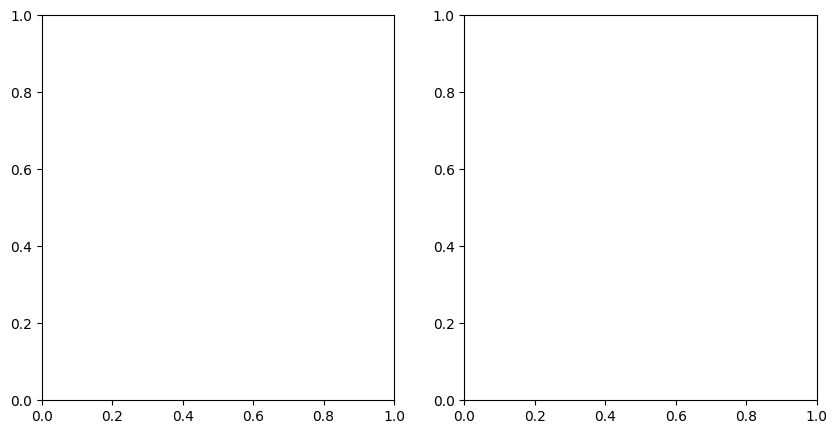

time: 350 ms (started: 2024-08-02 15:37:24 +00:00)


In [38]:
try:
    History(vgg19_history, model_name='VGG-19').plot_accuracy_and_lost()
    History(vgg19_history, model_name='VGG-19').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

In [39]:
try:
    history_df = history_to_dataframe(vgg19_history, 'vgg19')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")


Kesalahan: History training tidak ada!

time: 504 µs (started: 2024-08-02 15:37:24 +00:00)


## 7.3. EfficientNetV2B2

In [40]:
CALLBACKS = callbacks_list(
    monitor=Config.MONITOR,
    model_save_pathname='efficientnetv2b2_best_model.keras',
    early_stopping_patience=Config.ES_PATIENCE,
    learning_rate_patience=Config.LR_PATIENCE,
    learning_rate_scheme=Config.LR_SCHEME
)

efficientnetv2b2_history = train_model_with_callbacks(
    model=efficientnetv2b2_model,
    training_set=train_set,
    validation_set=valid_set,
    epochs=Config.EPOCH,
    batch_size=Config.BATCH_SIZE,
    verbose='auto',
    callbacks=CALLBACKS,
)

		START TRAINING

Epoch 1/1000


2024-08-02 15:39:49.532133: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,112,112]{3,2,1,0}, f32[64,128,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 15:39:49.678230: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.146210306s
Trying algorithm eng0{} for conv (f32[128,32,3,3]{3,2,1,0}, u8[0]{0}) custom-call(f32[64,32,112,112]{3,2,1,0}, f32[64,128,112,112]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBackwardFilter", backend_config={"conv_result_scale":1,"activation_mode":"kNone","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 15:39:51.084277: E exter


--------------------------------------------------
Kesalahan: Resource Exhausted (GPU Kehabisan Memori)!!!
--------------------------------------------------

		TRAINING COMPLETE
time: 3min 37s (started: 2024-08-02 15:37:24 +00:00)



Kesalahan: History training tidak ada!



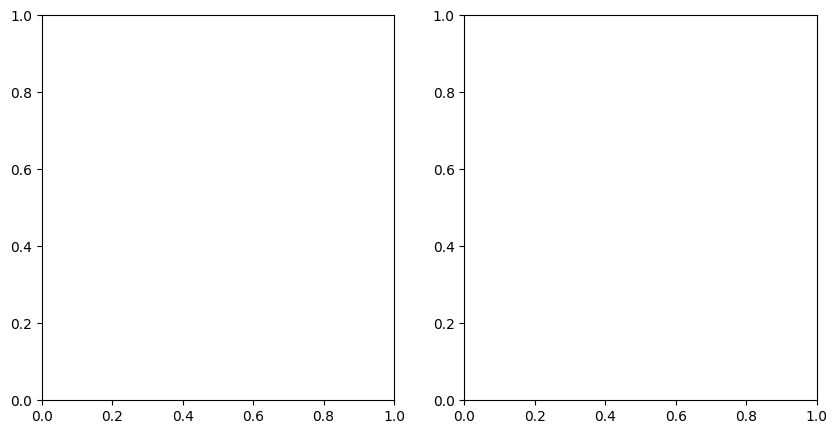

time: 312 ms (started: 2024-08-02 15:41:02 +00:00)


In [41]:
try:
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_accuracy_and_lost()
    History(efficientnetv2b2_history, model_name='EfficientNetV2B2').plot_learningrate()
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")

In [42]:
try:
    history_df = history_to_dataframe(efficientnetv2b2_history, 'efficientnetv2b2')
    history_df
except AttributeError:
    print("\nKesalahan: History training tidak ada!\n")


Kesalahan: History training tidak ada!

time: 1.05 ms (started: 2024-08-02 15:41:02 +00:00)


# 8. Evaluate

## 8.1. Custom CNN

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/4 ━━━━━━━━━━━━━━━━━━━━ 19s 6s/step

W0000 00:00:1722614706.716032     137 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


3/4 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step 

2024-08-02 16:05:26.837563: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng15{k5=1,k6=0,k7=1,k10=1} for conv (f32[26,32,446,446]{3,2,1,0}, u8[0]{0}) custom-call(f32[26,3,448,448]{3,2,1,0}, f32[32,3,3,3]{3,2,1,0}, f32[32]{0}), window={size=3x3}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"conv_result_scale":1,"activation_mode":"kRelu","side_input_scale":0,"leakyrelu_alpha":0} is taking a while...
2024-08-02 16:05:26.993174: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198916: 7.63618, expected 6.75751
2024-08-02 16:05:26.993212: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198920: 7.47463, expected 6.59596
2024-08-02 16:05:26.993221: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 198921: 6.99118, expected 6.11251
2024-08-02 16:05:26.993230: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137

4/4 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step
Custom CNN Classification Report
              precision    recall  f1-score   support

        Asli       0.92      0.39      0.55       165
       Palsu       0.32      0.89      0.47        53

    accuracy                           0.51       218
   macro avg       0.62      0.64      0.51       218
weighted avg       0.77      0.51      0.53       218



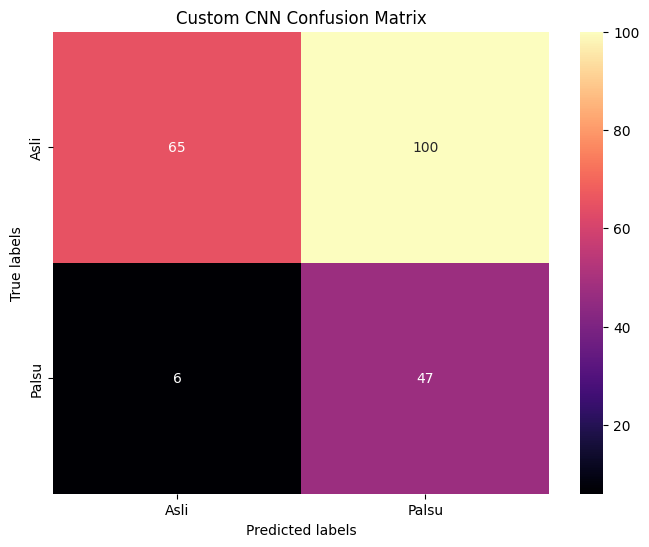

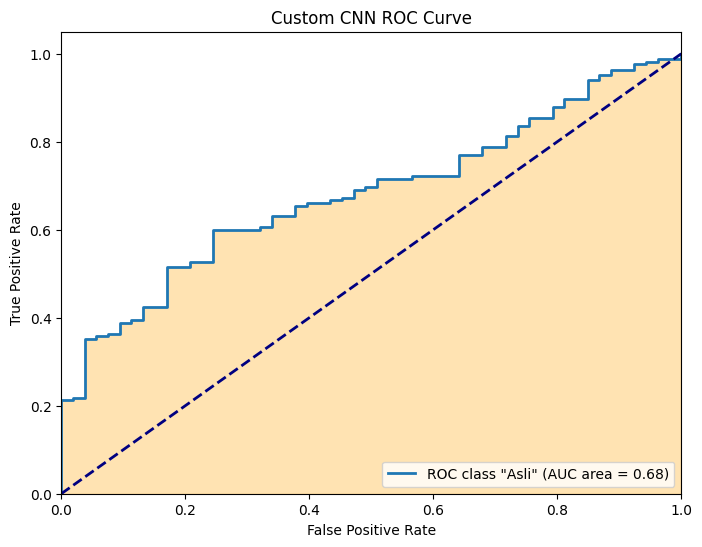

time: 49.3 s (started: 2024-08-02 16:04:43 +00:00)


In [44]:
try:
    cnn_best_model = load_model('cnn_best_model.keras')
    cnn_evaluator = ModelEvaluation(cnn_best_model, test_set, model_name='Custom CNN')

    cnn_y_true, cnn_y_pred = cnn_evaluator.predict_test()
    
    cnn_evaluator.classification_report()
    cnn_evaluator.plot_confusion_matrix()
    cnn_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

## 8.2. VGG-19

In [45]:
try:
    vgg19_best_model = load_model('vgg19_best_model.keras')
    vgg19_evaluator = ModelEvaluation(vgg19_best_model, test_set, model_name='VGG-19')

    vgg19_y_true, vgg19_y_pred = vgg19_evaluator.predict_test()
    
    vgg19_evaluator.classification_report()
    vgg19_evaluator.plot_confusion_matrix()
    vgg19_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

Kesalahan: File not found: filepath=vgg19_best_model.keras. Please ensure the file is an accessible `.keras` zip file. (Tidak ada model yang tersimpan) !!!
time: 1.08 ms (started: 2024-08-02 16:05:32 +00:00)


## 8.3. EfficientNetV2B2

In [46]:
try:
    efficientnetv2b2_best_model = load_model('efficientnetv2b2_best_model.keras')
    efficientnetv2b2_evaluator = ModelEvaluation(efficientnetv2b2_best_model, test_set, model_name='EfficientNetV2B2')

    efficientnetv2b2_y_true, efficientnetv2b2_y_pred = efficientnetv2b2_evaluator.predict_test()
    
    efficientnetv2b2_evaluator.classification_report()
    efficientnetv2b2_evaluator.plot_confusion_matrix()
    efficientnetv2b2_evaluator.plot_roc_auc()
except OSError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')
except ValueError as e:
    print(f'Kesalahan: {e} (Tidak ada model yang tersimpan) !!!')

Kesalahan: File not found: filepath=efficientnetv2b2_best_model.keras. Please ensure the file is an accessible `.keras` zip file. (Tidak ada model yang tersimpan) !!!
time: 9.31 ms (started: 2024-08-02 16:05:32 +00:00)


# 9. Hyperparameter Tuning for Best Model (Using Optuna)

In [47]:
# # Define the model
# def create_model(trial):
#   # Get the EfficientNetV2B base model
#   base_model = EfficientNetV2B(include_top=False, weights='imagenet', input_shape=(224, 224, 3))
#   base_model.trainable = False  # Freeze the base model weights

#   # Add custom layers for classification
#   x = GlobalAveragePooling2D()(base_model.output)
#   x = Dense(trial.suggest_int('units', 16, 512), activation='relu')(x)
#   outputs = Dense(10, activation='softmax')(x)

#   model = tf.keras.Model(inputs=base_model.input, outputs=outputs)

#   # Define optimizer based on trial suggestion
#   optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop', 'AdamW'])
#   if optimizer_name == 'Adam':
#     optimizer = Adam(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3))
#   elif optimizer_name == 'SGD':
#     optimizer = SGD(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1), momentum=trial.suggest_float('momentum', 0.0, 1.0))
#   elif optimizer_name == 'RMSprop':
#     optimizer = RMSprop(learning_rate=trial.suggest_float('learning_rate', 1e-4, 1e-1))
#   elif optimizer_name == 'AdamW':
#     optimizer = AdamW(learning_rate=trial.suggest_float('learning_rate', 1e-5, 1e-3))

#   # Compile the model
#   model.compile(optimizer=optimizer,
#                 loss='categorical_crossentropy', metrics=['accuracy'], callbacks=[reduce_lr, early_stop, model_checkpoint])

#   return model

# # Define the objective function
# def objective(trial):
#   # Create the model with trial parameters
#   model = create_model(trial)

#   # Load and train the model on your dataset (replace with your actual data)
#   # ...

#   # Evaluate the model's accuracy
#   accuracy = model.evaluate(x_test, y_test)['accuracy']

#   # Return the accuracy as the objective value
#   return accuracy

# # Create the Optuna study
# study = optuna.create_study(direction='maximize')

# # Start the optimization
# study.optimize(objective, n_trials=100)  # Set the number of trials as desired

# # Get the best trial
# best_trial = study.best_trial

# # Print the best parameters and accuracy
# print("Best parameters:")
# print("  optimizer:", best_trial.params['optimizer'])
# print("  units:", best_trial.params['units'])
# print("  learning_rate:", best_trial.params['learning_rate'])
# if best_trial.params['optimizer'] in ['SGD', 'RMSprop']:
#   print("  momentum:", best_trial.params.get('momentum'))
# print("Best accuracy:", best_trial.value)

time: 5.06 ms (started: 2024-08-02 16:05:32 +00:00)


# 10. Visualizing with Grad-CAM

"Gradient-weighted Class Activation Mapping (Grad-CAM), uses the gradients of any target concept (say 'dog' in a classification network or a sequence of words in captioning network) flowing into the final convolutional layer to produce a coarse localization map highlighting the important regions in the image for predicting the concept." **- Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization** (Ramprasaath R. Selvaraju, Michael Cogswell, Abhishek Das, Ramakrishna Vedantam, Devi Parikh, Dhruv Batra)

- Derivative of the class with the highest probability returned by the softmax layer is taken with respect to the final convolutional layer to produce a heat map which highlights the important regions in the image that activated the class.
- For full mathematical details please check out this paper: https://arxiv.org/abs/1610.02391

In [48]:
GradCAM_config = {
    'model_list' : {
        'custom_cnn' : cnn_model,
        'vgg19' : vgg19_model,
        'efficientnetv2b2' : efficientnetv2b2_model,
    },
    'last_conv_layer' : {
        'custom_cnn' : -5, # conv2d_4 (Conv2D)
        'vgg19' : -5, # block5_conv4 (Conv2D)
        'efficientnetv2b2' : -6, # top_conv (Conv2D)
    },
    'y_true' : {
        'custom_cnn' : cnn_y_true,
#         'vgg19' : vgg19_y_true,
#         'efficientnetv2b2' : efficientnetv2b2_y_true,
    },
    'y_pred' : {
        'custom_cnn' : cnn_y_pred,
#         'vgg19' : vgg19_y_pred,
#         'efficientnetv2b2' : efficientnetv2b2_y_pred,
    },
    'prob_threshold' : 0.75,
}

time: 7.26 ms (started: 2024-08-02 16:05:32 +00:00)


In [49]:
model = GradCAM_config['model_list']['efficientnetv2b2']
last_conv_layer = GradCAM_config['last_conv_layer']['efficientnetv2b2']
y_true = GradCAM_config['y_true']['efficientnetv2b2']
y_pred = GradCAM_config['y_pred']['efficientnetv2b2']
model.layers[last_conv_layer].output

KeyError: 'efficientnetv2b2'

time: 41.2 ms (started: 2024-08-02 16:05:32 +00:00)


In [ ]:
y_val = y_true
y_pred = y_pred
y_pred_classes = np.argmax(y_pred, axis=1)
y_pred_probs = np.max(y_pred, axis=1)

class_indices = test_set.class_indices
indices = {v:k for k,v in class_indices.items()}

filenames = test_set.filenames

val_df = pd.DataFrame()
val_df['filename'] = filenames
val_df['actual'] = y_val
val_df['predicted'] = y_pred_classes
val_df['probability'] = y_pred_probs
val_df['actual'] = val_df['actual'].apply(lambda x: indices[x])
val_df['predicted'] = val_df['predicted'].apply(lambda x: indices[x])
val_df.loc[val_df['actual']==val_df['predicted'],'Same'] = True
val_df.loc[val_df['actual']!=val_df['predicted'],'Same'] = False
val_df.head(10)

In [ ]:
val_df.describe().T

In [ ]:
number_of_correct_classfied = len(val_df[val_df['Same'] == True])
number_of_correct_classfied_asli = len(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Asli')])
number_of_correct_classfied_palsu = len(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Palsu')])
number_of_misclassfied = len(val_df[val_df['Same'] == False])
number_of_misclassfied_asli = len(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Asli')])
number_of_misclassfied_palsu = len(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Palsu')])
val_df = val_df.sample(frac=1).reset_index(drop=True)

### Image Visualization
- Correctly Classified (A and P are same)
- Misclassified (A and P are different)
- A: Actual P: Predicted

In [ ]:
def readImage(path):
    img = load_img(path,color_mode=Config.COLOR_MODE,target_size=(Config.IMAGE_SIZE,Config.IMAGE_SIZE))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df, image_range=1):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize=(20, 20))
    n = 0
    for i in range(image_range):
        n += 1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        image = readImage(f"{test_set_dir}/{temp_df.filename[i]}")
        if temp_df['Same'][i]:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'green'
        else:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'red'
        plt.imshow(image)
        plt.title(f'\n{temp_df.filename[i]}\nA: {temp_df.actual[i]} <> P: {temp_df.predicted[i]}\n[Prob: {temp_df.probability[i]:.2f}]', color=title_color)


### Number of Predictions and Visualized

In [ ]:
print(f'TOTAL prediksi BENAR : {number_of_correct_classfied}')
print(f'Jumlah prediksi benar ASLI  : {number_of_correct_classfied_asli}')
print(f'Jumlah prediksi benar PALSU : {number_of_correct_classfied_palsu}')
print('-'*50)
print(f'TOTAL prediksi SALAH : {number_of_misclassfied}')
print(f'Jumlah prediksi salah ASLI  : {number_of_misclassfied_asli}')
print(f'Jumlah prediksi salah PALSU : {number_of_misclassfied_palsu}')

In [ ]:
if number_of_correct_classfied_asli < 25:
    num_of_correct_visualizations_asli = number_of_correct_classfied_asli
else:
    num_of_correct_visualizations_asli = 25
    
if number_of_correct_classfied_palsu < 25:
    num_of_correct_visualizations_palsu = number_of_correct_classfied_palsu
else:
    num_of_correct_visualizations_palsu = 25
    
if number_of_misclassfied_asli < 25:
    num_of_incorrect_visualizations_asli = number_of_misclassfied_asli
else:
    num_of_incorrect_visualizations_asli = 25
    
if number_of_misclassfied_palsu < 25:
    num_of_incorrect_visualizations_palsu = number_of_misclassfied_palsu
else:
    num_of_incorrect_visualizations_palsu = 25
    
num_of_correct_visualizations_asli, num_of_correct_visualizations_palsu, num_of_incorrect_visualizations_asli, num_of_incorrect_visualizations_palsu

### Correctly Classified

#### Asli

In [ ]:
display_images(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Asli')], image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
display_images(val_df[(val_df['Same'] == True) & (val_df['actual'] == 'Palsu')], image_range=num_of_correct_visualizations_palsu)

### Misclassified

#### Asli

In [ ]:
display_images(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Asli')], image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
display_images(val_df[(val_df['Same'] == False) & (val_df['actual'] == 'Palsu')], image_range=num_of_incorrect_visualizations_palsu)

### Grad-CAM Computation
- Gradient computed of the final softmax layer with respect to the last convolution layer
- Mean of the gradients is then multiplied to the last convolution layer's output
- The output is then passed through a relu function to ensure that all values are positive

In [ ]:
def make_gradcam_heatmap(img_array, model, last_conv_layer=-3,  pred_index=None, ):

    grad_model = Model(inputs=model.inputs, outputs=[model.layers[last_conv_layer].output, model.output])

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy(), preds

### Grad-CAM Projection
- The heatmap produced using the Grad-CAM computation is then projected on to the original image
- The heatmap highlights the important parts of the image that lead to the activation of a class in the final softmax layer

In [ ]:
def gradCAMImage(image):
    path = f"{test_set_dir}/{image}"
    img = readImage(path)
    img = np.expand_dims(img,axis=0)
    heatmap,preds = make_gradcam_heatmap(img, model, last_conv_layer)

    img = load_img(path)
    img = img_to_array(img)
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * 0.8 + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    return superimposed_img

## Results

In [ ]:
def gradcam_of_images(correct_class, class_name, image_range=1):
    grad_images = []
    title = []
#     temp_df = val_df[val_df['Same']==correct_class]
    temp_df = val_df[(val_df['Same'] == correct_class) & (val_df['actual'] == class_name)]
    temp_df = temp_df.reset_index(drop=True)
    for i in range(image_range):
        image = temp_df.filename[i]
        grad_image = gradCAMImage(image)
        grad_images.append(grad_image)
        if correct_class:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'green'
        else:
            if temp_df.probability[i] < GradCAM_config['prob_threshold']:
                title_color = 'orange'
            else:
                title_color = 'red'
        title_text = f'\nA: {temp_df.actual[i]} <> P: {temp_df.predicted[i]}\n[Prob: {temp_df.probability[i]:.4f}]'
        title.append((title_text, title_color))

    return grad_images, title

### Correctly Classified

#### Asli

In [ ]:
correctly_classified_asli, c_titles_asli = gradcam_of_images(correct_class=True, class_name='Asli', image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
correctly_classified_palsu, c_titles_palsu = gradcam_of_images(correct_class=True, class_name='Palsu', image_range=num_of_correct_visualizations_palsu)

### Misclassified

#### Asli

In [ ]:
misclassified_asli, m_titles_asli = gradcam_of_images(correct_class=False, class_name='Asli', image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
misclassified_palsu, m_titles_palsu = gradcam_of_images(correct_class=False, class_name='Palsu', image_range=num_of_incorrect_visualizations_palsu)

## Display-Heatmaps

In [ ]:
def display_heatmaps(classified_images, titles, image_range=1):
    plt.figure(figsize = (20, 20))
    n = 0
    for i in range(image_range):
        n+=1
        plt.subplot(5, 5, n)
        plt.subplots_adjust(hspace = 0.5 , wspace = 0.3)
        plt.imshow(classified_images[i])
        plt.title(titles[i][0], color=titles[i][1])
    plt.show()

### Grad-CAM: Correctly Classified

#### Asli

In [ ]:
display_heatmaps(classified_images=correctly_classified_asli, titles=c_titles_asli, image_range=num_of_correct_visualizations_asli)

#### Palsu

In [ ]:
display_heatmaps(classified_images=correctly_classified_palsu, titles=c_titles_palsu, image_range=num_of_correct_visualizations_palsu)

### Grad-CAM: Incorrectly Classified

#### Asli

In [ ]:
display_heatmaps(classified_images=misclassified_asli, titles=m_titles_asli, image_range=num_of_incorrect_visualizations_asli)

#### Palsu

In [ ]:
display_heatmaps(classified_images=misclassified_palsu, titles=m_titles_palsu, image_range=num_of_incorrect_visualizations_palsu)

# 11. Model Deployment to Flutter

In [ ]:
print(train_set.class_indices)
labels = '\n'.join(sorted(
    train_set.class_indices.keys()
))

with open('labels.txt', 'w') as f:    
    f.write(labels)

In [ ]:
saved_model_dir = ''
tf.saved_model.save(model, saved_model_dir)

converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_dir)
tflite_model = converter.convert()

with open('real_fake_rupiah.tflite', 'wb') as f:
    f.write(tflite_model)